In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
#import seaborn as sns
from visualize_foreground import *

R_sun = 6.957e10
G = 6.6743e-8

sns.set_style("whitegrid")  # Use "white", "dark", "whitegrid", "darkgrid" or "ticks"
sns.set_context("talk")     # Use "paper", "talk", "poster" for different sizes

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [6]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r_over_R = np.array(f['/r_over_R'])
        c_s = np.array(f['/c_s'])
        Gamma_1 = np.array(f['/Gamma_1'])
        T0 = np.array(f['/T'])
        rho0 = np.array(f['/rho'])
        p0 = np.array(f['/p'])
        
        r_over_R = np.flip(r_over_R)
        c_s = np.flip(c_s)
        Gamma_1 = np.flip(Gamma_1)
        T0 = np.flip(T0)
        rho0 = np.flip(rho0)
        p0 = np.flip(p0)

        variables = {'r_over_R': r_over_R, 'c_s': c_s, 'Gamma_1': Gamma_1, 'T0': T0, 'rho0': rho0, 'p0': p0}
    return variables

In [16]:
solar_S = read_solar_S_hdf5("../additional_files/solar_s.h5")

RUN_NAME = "new_bg_test/"
SAVE_DIR = "/mn/stornext/d10/data/tabjone/data/"

var, info = read_bg_mpi(3, SAVE_DIR + RUN_NAME)

In [56]:
solar_S['M'] = 4*np.pi*R_sun**3 * cumtrapz(solar_S['rho0']*(solar_S['r_over_R'])**2, solar_S['r_over_R'], initial=0)
solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_sun)**2)

var['H'] = var['p0']/(var['rho0']*var['g'])
solar_S['H'] = -solar_S['p0']/(solar_S['rho0']*solar_S['g'])

/tmp/ipykernel_4171879/323098222.py:2: RuntimeWarning: invalid value encountered in divide
  solar_S['g'] = -G*solar_S['M']/((solar_S['r_over_R']*R_sun)**2)


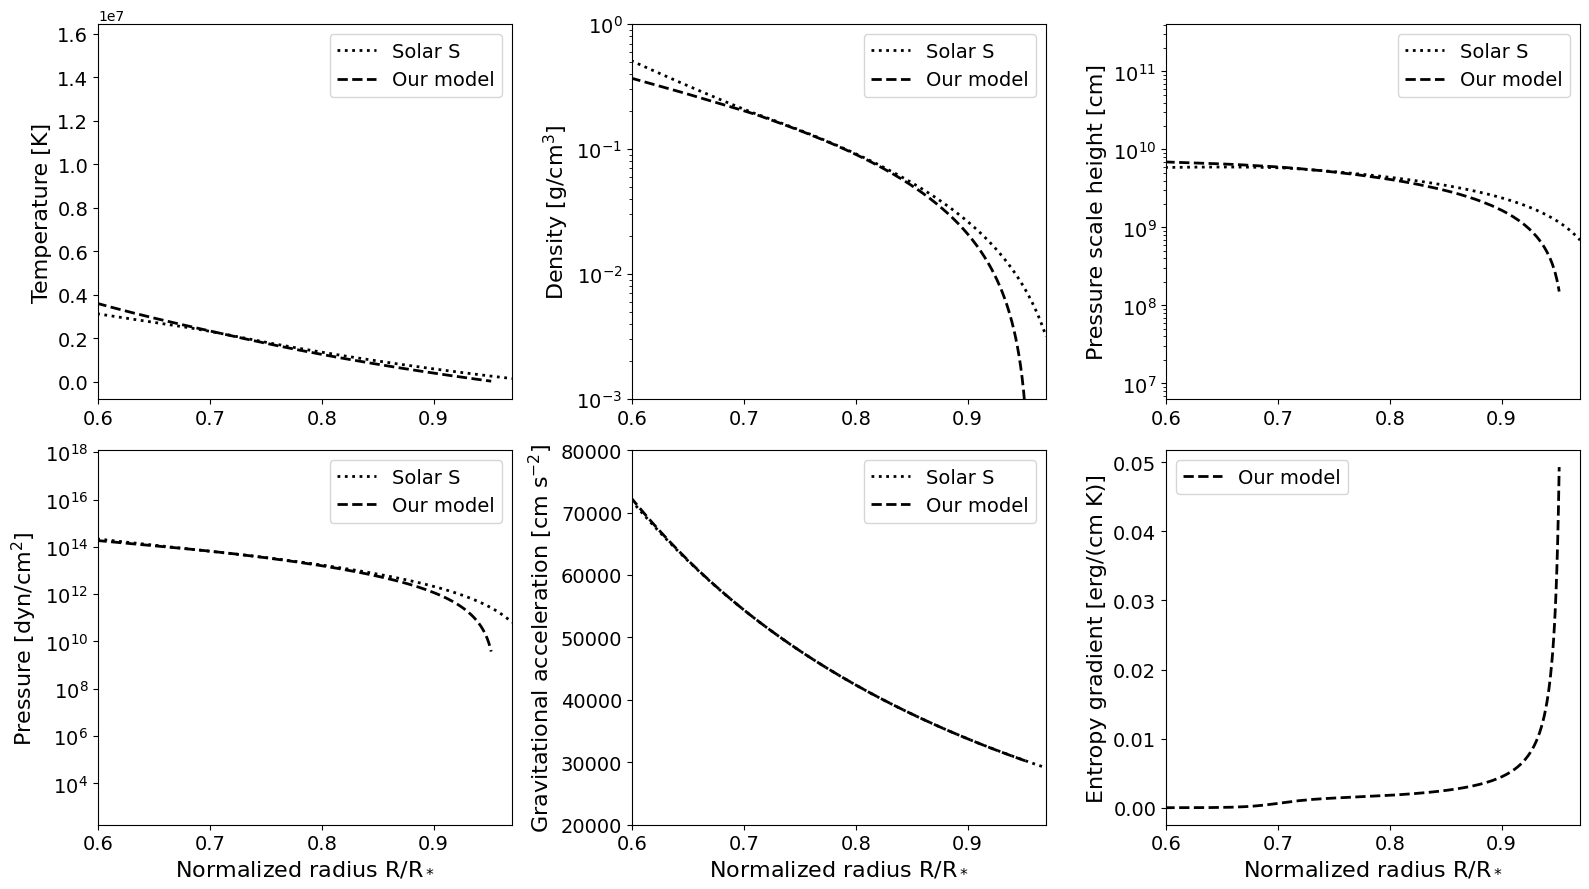

In [58]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 9))

ax[0][0].plot(solar_S['r_over_R'], solar_S['T0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax[0][0].plot(var['r']/R_sun, var['T0'], color="black", linestyle="--", linewidth=2, label="Our model")

ax[1][0].semilogy(solar_S['r_over_R'], solar_S['p0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax[1][0].semilogy(var['r']/R_sun, var['p0'], color="black", linestyle="--", linewidth=2, label="Our model")

ax[0][1].semilogy(solar_S['r_over_R'], solar_S['rho0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax[0][1].semilogy(var['r']/R_sun, var['rho0'], color="black", linestyle="--", linewidth=2, label="Our model")
ax[0][1].set_xlim(0.6, 0.97)
ax[0][1].set_ylim(1e-3, 1e0)
#ax.yaxis.set_major_formatter(formatter)
ax[0][1].set_ylabel("Density [g/cm$^3$]", fontsize=16)

ax[1][1].plot(solar_S['r_over_R'], np.abs(solar_S['g']), color="black", linestyle=":", linewidth=2, label="Solar S")
ax[1][1].plot(var['r']/R_sun, var['g'], color="black", linestyle="--", linewidth=2, label="Our model")
ax[1][1].set_xlim(0.6, 0.97)
ax[1][1].set_ylim(0.2e5, 0.8e5)
ax[1][1].set_xlabel("Radius [Solar radii]", fontsize=16)
ax[1][1].set_ylabel("Gravitational acceleration [cm s$^{-2}$]", fontsize=16)

ax[0][2].semilogy(solar_S['r_over_R'], solar_S['H'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax[0][2].semilogy(var['r']/R_sun, var['H'], color="black", linestyle="--", linewidth=2, label="Our model")
ax[0][2].set_ylabel("Pressure scale height [cm]", fontsize=16)

ax[1][2].plot(var['r']/R_sun, var['grad_s0'], color="black", linestyle="--", linewidth=2, label="Our model")
ax[1][2].set_ylabel("Entropy gradient [erg/(cm K)]", fontsize=16)

for ax_ in ax:
    for axis in ax_:
        axis.tick_params(axis='both', labelsize=14)
        axis.legend(fontsize=14)
        axis.set_xlim(0.6, 0.97)
        #axis.yaxis.set_major_formatter(formatter)
        #axis.grid(True, which="both", ls="-", color='0.65')

for i in range(3):
    ax[1][i].set_xlabel("Normalized radius R/R$_*$", fontsize=16)

ax[0][0].set_ylabel("Temperature [K]", fontsize=16)
ax[1][0].set_ylabel("Pressure [dyn/cm$^2$]", fontsize=16)

fig.tight_layout()
plt.show()

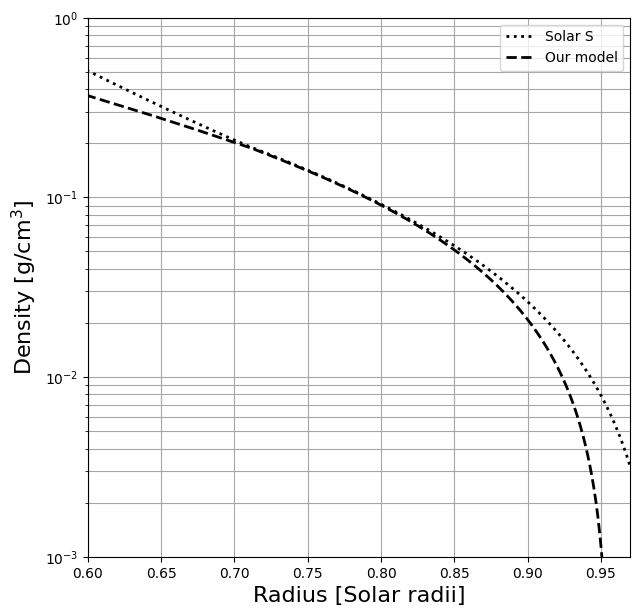

In [20]:
fig, ax = plt.subplots(figsize=(7, 7))
formatter.set_powerlimits((-1, 1))  # you can adjust these limits if needed

#set grid on plot
ax.grid(True, which="both", ls="-", color='0.65')

ax.semilogy(solar_S['r_over_R'], solar_S['rho0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax.semilogy(var['r']/R_sun, var['rho0'], color="black", linestyle="--", linewidth=2, label="Our model")
ax.set_xlim(0.6, 0.97)
ax.set_ylim(1e-3, 1e0)
#ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Radius [Solar radii]", fontsize=16)
ax.set_ylabel("Density [g/cm$^3$]", fontsize=16)
ax.legend()
#fig.tight_layout()
#plt.savefig("../thesis/mastermal-ita/solar_vs_model_plots/Density.pdf")
plt.show()

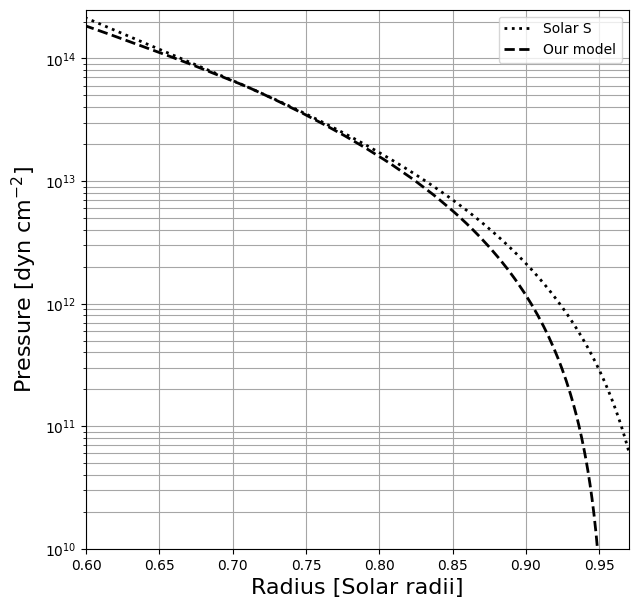

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.semilogy(solar_S['r_over_R'], solar_S['p0'], color="black", linestyle=":", linewidth=2, label="Solar S")
ax.semilogy(var['r']/R_sun, var['p0'], color="black", linestyle="--", linewidth=2, label="Our model")
ax.set_xlim(0.6, 0.97)
ax.set_ylim(1e10, 2.5e14)
#ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Radius [Solar radii]", fontsize=16)
ax.set_ylabel("Pressure [dyn cm$^{-2}$]", fontsize=16)
ax.legend()

#set grid on plot
ax.grid(True, which="both", ls="-", color='0.65')

#fig.tight_layout()
#plt.savefig("../thesis/mastermal-ita/solar_vs_model_plots/Pressure.pdf")
plt.show()

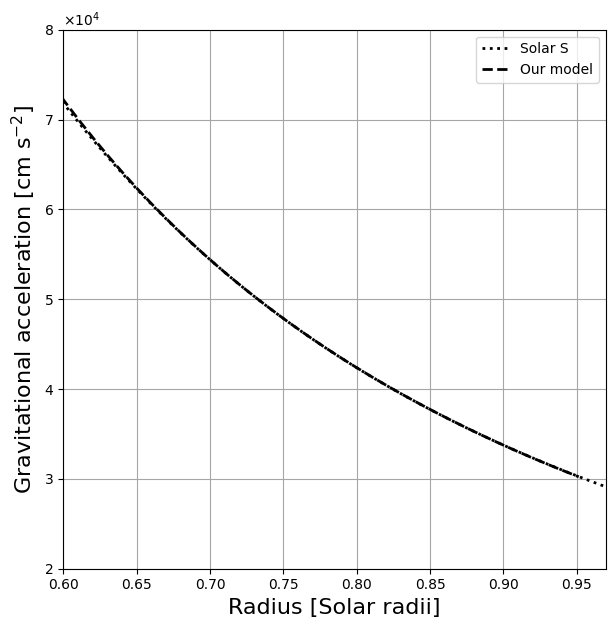

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(solar_S['r_over_R'], np.abs(solar_S['g']), color="black", linestyle=":", linewidth=2, label="Solar S")
ax.plot(var['r']/R_sun, var['g']) color="black", linestyle="--", linewidth=2, label="Our model")
ax.set_xlim(0.6, 0.97)
ax.set_ylim(0.2e5, 0.8e5)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Radius [Solar radii]", fontsize=16)
ax.set_ylabel("Gravitational acceleration [cm s$^{-2}$]", fontsize=16)

#set grid on plot
ax.grid(True, which="both", ls="-", color='0.65')

ax.legend()

#fig.tight_layout()
plt.savefig("../thesis/mastermal-ita/solar_vs_model_plots/Gravitational_acceleration.pdf")
plt.show()

Text(0, 0.5, 'Pressure scale height (cm)')

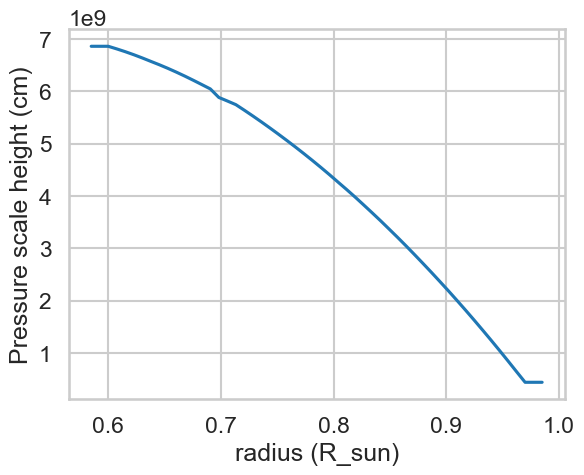

In [28]:
H = -p0_/(rho0_*g_)
plt.plot(r_/R_sun, H)
plt.xlabel("radius (R_sun)")
plt.ylabel("Pressure scale height (cm)")

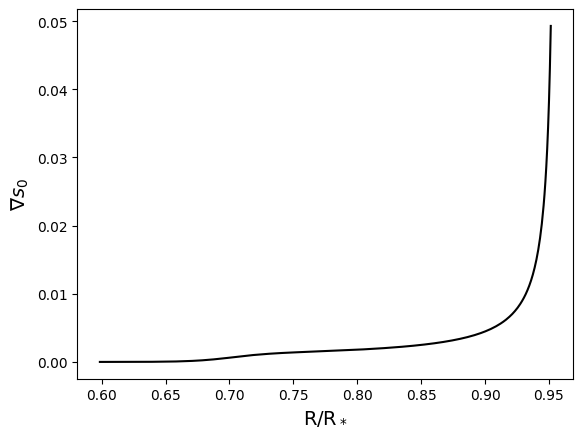

In [37]:
#plt.scatter(r_/R_sun, grad_s0_, color="black", s=10)
plt.plot(var['r']/R_sun, var['grad_s0'], color="black")
plt.xlabel("R/R$_*$", fontsize=14)
plt.ylabel(r"$\nabla s_0$", fontsize=14)
plt.show()

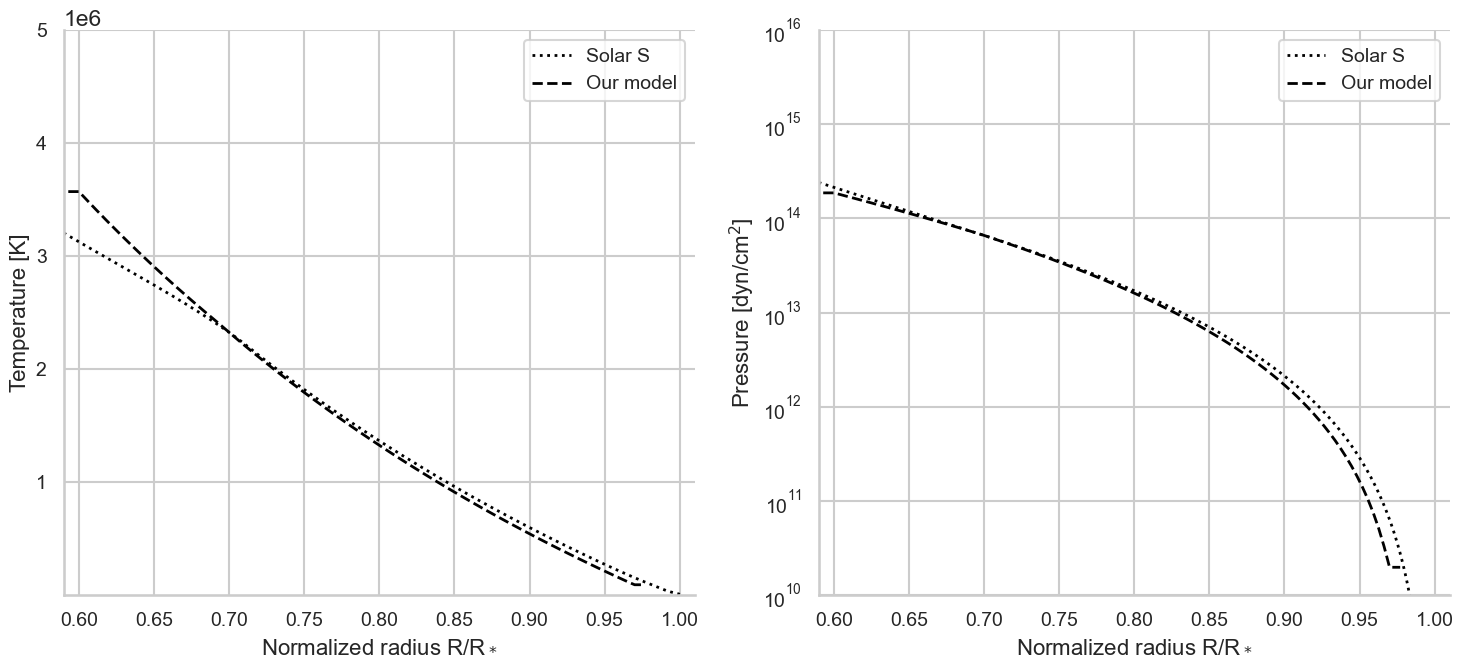

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))

ax[0].plot(r_over_R, T0, color="black", linestyle=":", linewidth=2, label="Solar S")
ax[0].plot(r_/R_sun, T0_, color="black", linestyle="--", linewidth=2, label="Our model")

ax[1].semilogy(r_over_R, p0, color="black", linestyle=":", linewidth=2, label="Solar S")
ax[1].semilogy(r_/R_sun, p0_, color="black", linestyle="--", linewidth=2, label="Our model")

for axis in ax:
    axis.tick_params(axis='both', labelsize=14)
    axis.set_xlabel("Normalized radius R/R$_*$", fontsize=16)
    axis.legend(fontsize=14)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

ax[0].set_xlim(0.59, 1.01)
ax[0].set_ylim(1e3, 0.5e7)
ax[0].set_ylabel("Temperature [K]", fontsize=16)

ax[1].set_xlim(0.59, 1.01)
ax[1].set_ylim(1e10, 1e16)
ax[1].set_ylabel("Pressure [dyn/cm$^2$]", fontsize=16)

fig.tight_layout()
plt.show()

In [7]:
R_sun = 6.957e10
M_sun = 1.989e33
G = 6.6743e-8

M = 4*np.pi*R_sun**3 * cumtrapz(rho0*(r_over_R)**2, r_over_R, initial=0)
g = -G*M/((r_over_R*R_sun)**2)

/var/folders/k6/k6jkpmqs13l4qhz_xy4wzlmw0000gn/T/ipykernel_61115/103677430.py:6: RuntimeWarning: invalid value encountered in divide
  g = -G*M/((r_over_R*R_sun)**2)


NameError: name 'r_over_R' is not defined

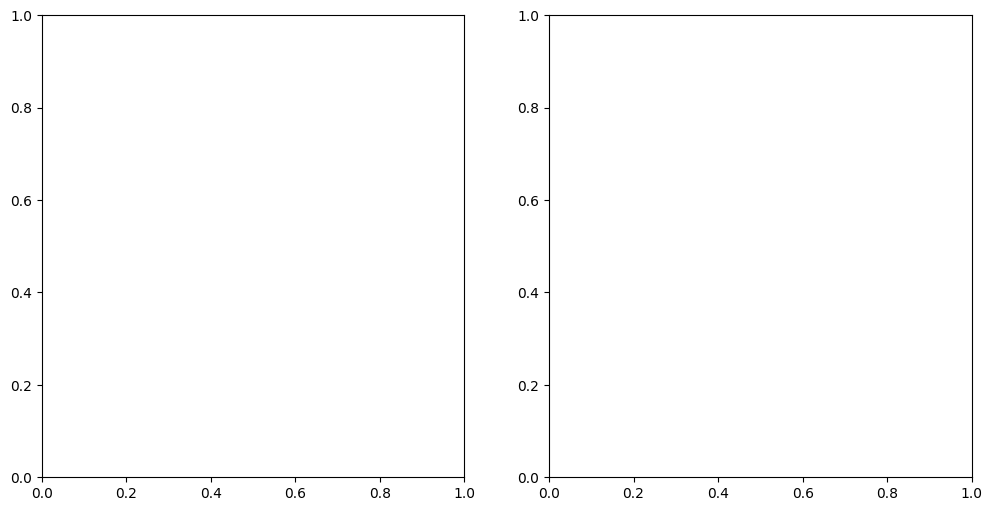

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].semilogy(r_over_R, np.abs(g), color="black", linestyle=":", label="Solar S")
ax[0].semilogy(r_/R_sun, g_, color="black", linestyle="--", label="Our model")

ax[1].semilogy(r_over_R, rho0, color="black", linestyle=":", label="Solar S")
ax[1].semilogy(r_/R_sun, rho0_, color="black", linestyle="--", label="Our model")

ax[0].set_xlim(0.59,1.01)
ax[0].set_ylim(2e4,1e5)
ax[0].set_xlabel("Normalized radius R/R$_*$")
ax[0].set_ylabel("Gravitational acceleration [cm$^4$/(gs$^2$)]")
ax[0].legend()

ax[1].set_xlim(0.59,1.01)
ax[1].set_ylim(1e-3,0.1e1)
ax[1].set_xlabel("Normalized radius R/R$_*$")
ax[1].set_ylabel("Density [g/cm$^3$]")
ax[1].legend()

fig.tight_layout()
plt.show()

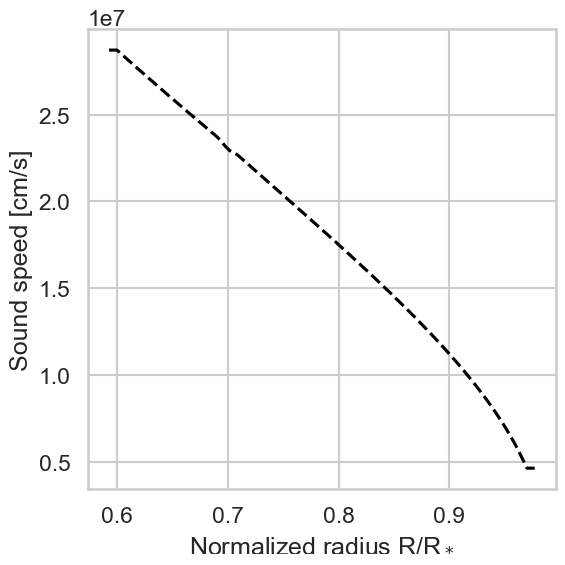

In [29]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(r_/R_sun, np.sqrt(5/3 * p0_/rho0_), color="black", linestyle="--")

#ax[0].set_ylim(2e4,1e5)
ax.set_xlabel("Normalized radius R/R$_*$")
ax.set_ylabel("Sound speed [cm/s]")


fig.tight_layout()
plt.show()